<a href="https://colab.research.google.com/github/ppdevexe/ml-projects/blob/master/logisticregression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import sys
import pandas as pd
import tensorflow.compat.v2.feature_column as fc
from __future__ import absolute_import,division,print_function,unicode_literals
from IPython.display import clear_output
from six.moves import urllib

In [ ]:
!pip install sklearn


In [ ]:
df_train=pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
df_eval=pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train=df_train.pop('survived')
y_eval=df_eval.pop('survived')

In [ ]:
df_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [ ]:
df_train.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


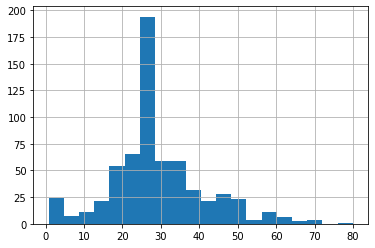

In [ ]:
df_train.age.hist(bins=20)

Text(0.5, 0, '% survive')

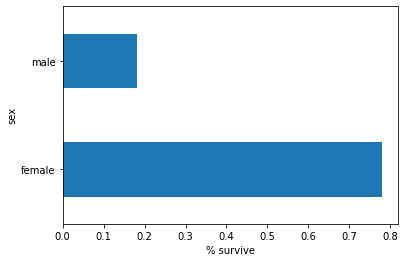

In [ ]:
pd.concat([df_train,y_train],axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')


In [ ]:
categorical_columns=['sex','n_siblings_spouses','parch','class','deck','embark_town','alone']
numeric_columns=['age','fare']
feature_columns=[]
for feature_name in categorical_columns:
  vocabulary=df_train[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name,vocabulary))
for feature_name in numeric_columns:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,dtype=tf.float32))


In [ ]:
def make_input_fn(data_df,label_df,num_epochs=10,shuffle=True,batch_size=32):
  def input_function():
    ds=tf.data.Dataset.from_tensor_slices((dict(data_df),label_df))
    if shuffle:
      ds=ds.shuffle(1000)
    ds=ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function
train_df=make_input_fn(df_train,y_train)
eval_input_fn=make_input_fn(df_eval,y_eval,num_epochs=1,shuffle=False)

In [ ]:
ds=make_input_fn(df_train,y_train,batch_size=10)()
for feature_batch,label_batch in ds.take(1):
  print('some feature keys',list(feature_batch.keys()))
  print()
  print('a batch of class',feature_batch['class'].numpy())
  print()
  print('a batch of labels',label_batch.numpy())
  

some feature keys ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

a batch of class [b'Second' b'First' b'Second' b'Third' b'Third' b'Third' b'First' b'Third'
 b'Third' b'Second']

a batch of labels [1 0 0 0 1 0 1 0 1 1]


In [ ]:
age_column=feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()
gender_column=feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()
linear_est=tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_df)
result=linear_est.evaluate(eval_input_fn)
clear_output()
print(result)

{'accuracy': 0.7537879, 'accuracy_baseline': 0.625, 'auc': 0.8280685, 'auc_precision_recall': 0.7662165, 'average_loss': 0.51886016, 'label/mean': 0.375, 'loss': 0.5172519, 'precision': 0.64166665, 'prediction/mean': 0.46186787, 'recall': 0.7777778, 'global_step': 200}


In [ ]:
age_x_gender=tf.feature_column.crossed_column(['age','sex'],hash_bucket_size=100)


In [ ]:
derived_feature_column=[age_x_gender]
linear_est=tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_column)
linear_est.train(train_df)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpn3678hl_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. 

In [ ]:
result=linear_est.evaluate(eval_input_fn)
clear_output()
print(result)

{'accuracy': 0.7386364, 'accuracy_baseline': 0.625, 'auc': 0.826783, 'auc_precision_recall': 0.7573682, 'average_loss': 0.60063714, 'label/mean': 0.375, 'loss': 0.60049534, 'precision': 0.6086956, 'prediction/mean': 0.5572768, 'recall': 0.8484849, 'global_step': 200}


INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpn3678hl_/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


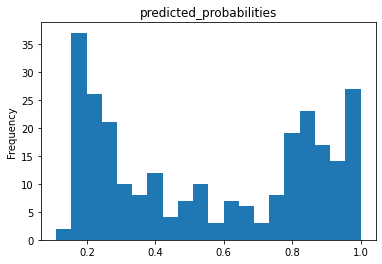

In [ ]:
pred_dicts=list(linear_est.predict(eval_input_fn))
probs=pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.plot(kind='hist',bins=20,title='predicted_probabilities')


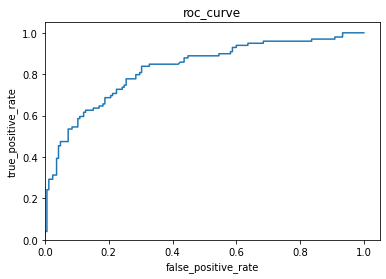

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
fpr,tpr,_=roc_curve(y_eval,probs)
plt.plot(fpr,tpr)
plt.title('roc_curve')
plt.xlabel('false_positive_rate')
plt.ylabel('true_positive_rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()